In [1]:
# Initialize the notebook
using Pkg
Pkg.activate("..")
#include("../src/Particles.jl")
using Particles
using Plots
using Zarr
using ZipFile

nothing

  Activating project at `~/verlaan_shared/src/julia/Particles2`


In [2]:
# unzip the test data

# function unzip(file,exdir="")
# extract all files from zip file to exdir
function unzip(file,exdir="")
    fileFullPath = isabspath(file) ?  file : joinpath(pwd(),file)
    basePath = dirname(fileFullPath)
    outPath = (exdir == "" ? basePath : (isabspath(exdir) ? exdir : joinpath(pwd(),exdir)))
    isdir(outPath) ? "" : mkdir(outPath)
    zarchive = ZipFile.Reader(fileFullPath)
    for f in zarchive.files
        fullFilePath = joinpath(outPath,f.name)
        if (endswith(f.name,"/") || endswith(f.name,"\\"))
            mkdir(fullFilePath)
        else
            write(fullFilePath, read(f))
        end
    end
    close(zarchive)
end

unzip("./data/locxxz_fullgrid_map.zip","./data")

In [4]:
Zarr_data = ZarrData("./data","locxxz_fullgrid_map.zarr")
t0=get_reftime(Zarr_data)
h=initialize_interpolation(Zarr_data,"waterlevel",t0)
u=initialize_interpolation(Zarr_data,"x_velocity",t0)
w=initialize_interpolation(Zarr_data,"z_velocity",t0)
s=initialize_interpolation(Zarr_data,"salinity",t0)
nu=initialize_interpolation(Zarr_data,"eddy_visc_z",t0)

nothing

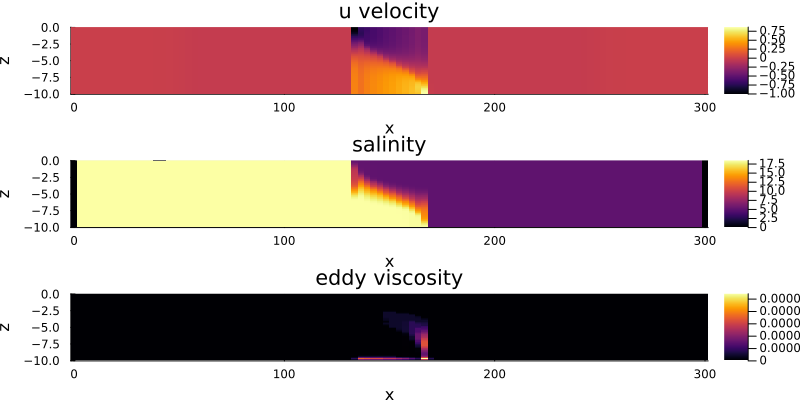

In [5]:
x_left = 0.0
x_middle = 150.0
x_right = 300.0
y_middle = 0.5
z_surface = 0.0
z_middle = -5.0
z_bottom = -10.0
t=40.0

# grid for plotting only
x_points = range(x_left,stop=x_right,length=100)
z_points = range(z_bottom,stop=z_surface,length=100)
u_interp = [u(x,y_middle,z,t) for x in x_points, z in z_points] # x velocity
w_interp = [w(x,y_middle,z,t) for x in x_points, z in z_points] # z velocity
s_interp = [s(x,y_middle,z,t) for x in x_points, z in z_points] # salinity
nu_interp = [nu(x,y_middle,z,t) for x in x_points, z in z_points] # eddy viscosity

l = @layout([a; b; c])
p1=heatmap(x_points,z_points,u_interp',xlabel="x",ylabel="z",title="u velocity")
p2=heatmap(x_points,z_points,s_interp',xlabel="x",ylabel="z",title="salinity")
p3=heatmap(x_points,z_points,nu_interp',xlabel="x",ylabel="z",title="eddy viscosity")
plot(p1,p2,p3,layout=l,size=(800,400))